## Traction Analytics Prediction

### Methodology

1. Data Preparation
- Concat daily downloads of weekly article activities from NewsWhip
- Calculate percentage and absolute change of each article across days

2. Define labels
- Set gradient threshold and abs interaction value threshold
- For each article, build a linear regression model for the facebook interactions over time and obtain the gradient
- If the gradient > threshold | abs interaction count > threshold -> trending
- Else if the gradient < -threshold -> untrending
- Else -> neutral

3. EDA of labels
- Readjust threholds if necessary
- Under or oversampling if necessary

4. Deep learning pipeline (SetFit for Few Shot)
- Tokenise
- Train-test split : 80/20
- Model evaluation using precision, recall and F1
- Model comparison

### Data Preperation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [2]:
# Read and perform basic data processing

df = pd.read_csv('data/combined_data_merged.csv')
df = df[['published', 'headline', 'summary', 'link', 'domain','facebook_interactions', 'date_extracted']]
df['published'] = pd.to_datetime(df['published'])
df['date_extracted'] = pd.to_datetime(df['date_extracted'])
df = df.sort_values(by=['headline', 'published', 'date_extracted'], ascending=[False, True, True]).reset_index(drop=True)

df

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09
...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08


In [3]:
# Create a dataframe with unique articles only

df_unique = df.drop_duplicates(subset=['headline', 'published'], keep='first').reset_index(drop=True)
df_unique

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09
...,...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16


### Domain Analysis

In [4]:
df_unique['domain'].value_counts()

straitstimes.com                    285
mothership.sg                       276
asiaone.com                         169
channelnewsasia.com                 158
mustsharenews.com                    86
sg.news.yahoo.com                    80
sg.style.yahoo.com                   63
todayonline.com                      48
stomp.straitstimes.com               42
cnalifestyle.channelnewsasia.com     39
tnp.straitstimes.com                 32
sg.finance.yahoo.com                 12
babelfish.mothership.sg              11
coconuts.co                           6
goodyfeed.com                         6
businesstimes.com.sg                  4
au.news.yahoo.com                     4
uk.news.yahoo.com                     3
theonlinecitizen.com                  2
au.lifestyle.yahoo.com                2
ricemedia.co                          2
cnaluxury.channelnewsasia.com         2
malaysia.news.yahoo.com               1
public.flourish.studio                1
Name: domain, dtype: int64

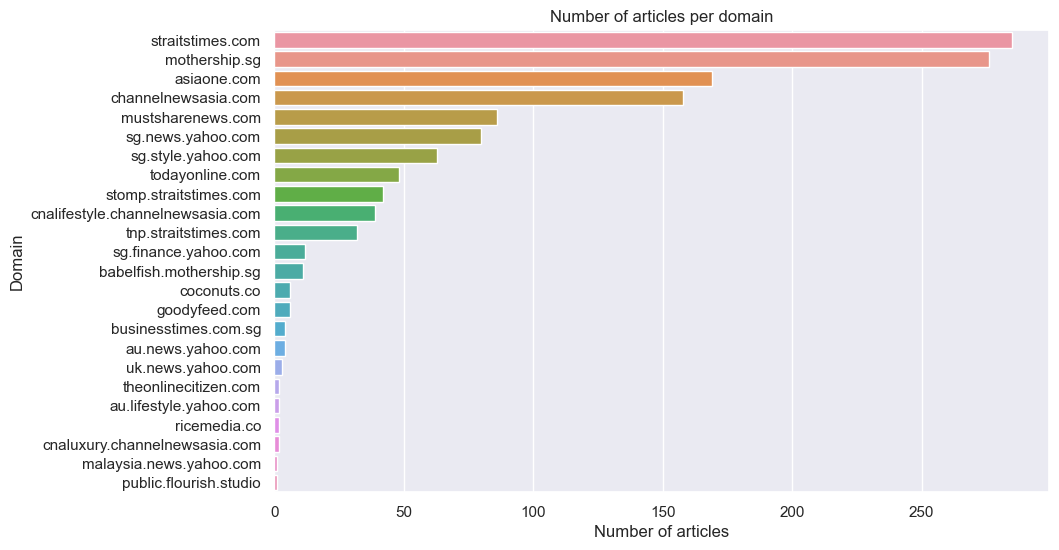

In [5]:
#plot the number of articles per domain

plt.figure(figsize=(10, 6))
sns.countplot(y='domain', data=df_unique, order=df_unique['domain'].value_counts().index)
plt.title('Number of articles per domain')
plt.xlabel('Number of articles')
plt.ylabel('Domain')
plt.show()

In [6]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key
        
reverse_domain_map

{'asiaone.com': 'asiaone',
 'businesstimes.com.sg': 'businesstimes',
 'channelnewsasia.com': 'channelnewsasia',
 'cnalifestyle.channelnewsasia.com': 'channelnewsasia',
 'cnaluxury.channelnewsasia.com': 'channelnewsasia',
 'goodyfeed.com': 'goodyfeed',
 'babelfish.mothership.sg': 'mothership',
 'mothership.sg': 'mothership',
 'mustsharenews.com': 'mustsharenews',
 'ricemedia.co': 'ricemedia',
 'straitstimes.com': 'straitstimes',
 'stomp.straitstimes.com': 'stomp',
 'tnp.straitstimes.com': 'thenewpaper',
 'theonlinecitizen.com': 'theonlinecitizen',
 'todayonline.com': 'today',
 'sg.finance.yahoo.com': 'yahoosingapore',
 'sg.news.yahoo.com': 'yahoosingapore',
 'sg.style.yahoo.com': 'yahoosingapore'}

In [7]:
domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],

}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})
traffic_table

,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,asiaone,4990000,1290000
1,businesstimes,1630000,622688
2,channelnewsasia,14760000,2330000
3,goodyfeed,891376,461731
4,mothership,6770000,1660000
5,mustsharenews,2010000,823526
6,ricemedia,148791,86394
7,straitstimes,12310000,2230000
8,stomp,1270000,427113
9,theindependent,2370000,683818


Filtering data to include only articles present in mapping table

In [8]:
df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09
...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08


In [9]:
df_filtered = df_unique[df_unique["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df_filtered

,published,headline,summary,link,domain,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09
...,...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16


In [10]:
# mapping domain to domain group

df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)
df_filtered

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2727172548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia
...,...,...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13,today
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12,today
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12,today
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16,today


In [11]:
# merge traffic table with df_filtered on domain and domain_group respectively

df_unique = df_filtered.merge(traffic_table, on='domain_group', how='left')
df_unique


,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today,3660000,1170000
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes,12310000,2230000
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes,12310000,2230000
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000
...,...,...,...,...,...,...,...,...,...,...
1312,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,todayonline.com,1016,2023-05-13,today,3660000,1170000
1313,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,todayonline.com,1091,2023-05-12,today,3660000,1170000
1314,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,todayonline.com,664,2023-05-12,today,3660000,1170000
1315,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,todayonline.com,779,2023-05-16,today,3660000,1170000


In [12]:
# Calculate the absolute and percentage change in facebook interactions for each article

df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)
# df['facebook_interactions_pct_change'] = df.groupby('link')['facebook_interactions'].pct_change().fillna(0)
df

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\1948972086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,facebook_interactions_abs_change
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,0.0
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,101.0
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,182.0
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,49.0
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,25.0
...,...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04,0.0
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05,84.0
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07,170.0
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08,32.0


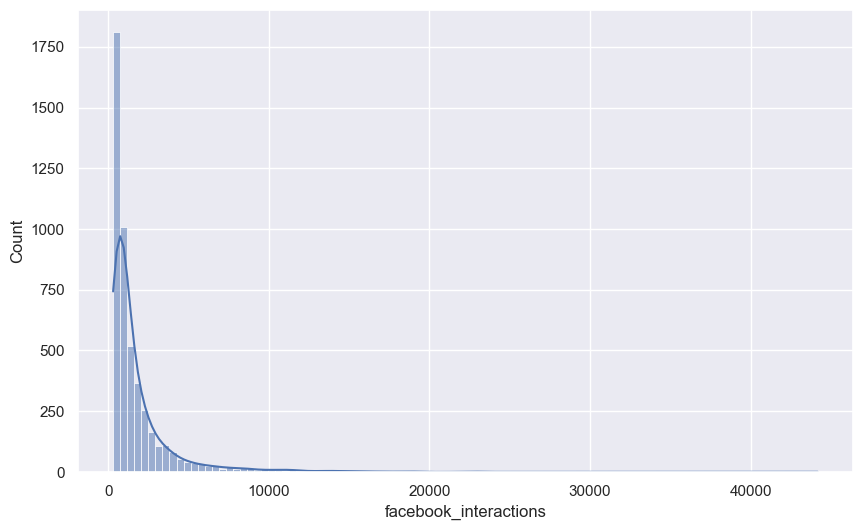

In [13]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions', bins=100, kde=True)
plt.show()


#### Using gradient within each article

Benefits:
- Smoothens based on weekly activities

Issues:
- Reduces impact of spikes
- Gradient threshold not very explainable

In [14]:
from sklearn.linear_model import LinearRegression

# calculating mean and gradient of facebook interactions for each article

def cal_article_mean_and_gradient(val_array):
    val_array = np.asarray(val_array)
    mean = np.mean(val_array)
    val_array = np.nan_to_num(val_array)

    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]

    return mean, gradient


In [15]:
# Create a dataframe with unique articles and their corresponding labels

df_labels = df.groupby('link')['facebook_interactions'].agg(cal_article_mean_and_gradient).reset_index()

# Merge the unique articles dataframe with the labels dataframe

df_labelled = df_unique.merge(df_labels, on='link', how='left')
df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'mean_and_gradient'})
df_labelled['mean'] = df_labelled['mean_and_gradient'].apply(lambda x: x[0])
df_labelled['gradient'] = df_labelled['mean_and_gradient'].apply(lambda x: x[1])
df_labelled.drop(columns=['mean_and_gradient'], inplace=True)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,mean,gradient
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today,3660000,1170000,1565.6,94.5
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes,12310000,2230000,1677.6,136.7
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes,12310000,2230000,1736.4,169.7
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526,607.0,66.2
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000,1747.5,136.2


In [16]:
# Convert negative gradient to 0

df_labelled['gradient'] = df_labelled['gradient'].apply(lambda x: 0 if x < 0 else x)

In [77]:
# normalising the mean and gradient values on a gaussian distribution

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

df_labelled['mean_s_scaled'] = StandardScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_s_scaled'] = StandardScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_r_scaled'] = RobustScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_r_scaled'] = RobustScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['mean']])
df_labelled['gradient_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['gradient']])

df_labelled['mean_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['mean']])
df_labelled['gradient_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['gradient']])

df_labelled['mean_log'] = np.log(df_labelled['mean'])
df_labelled['gradient_log'] = np.log(df_labelled['gradient'])



e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


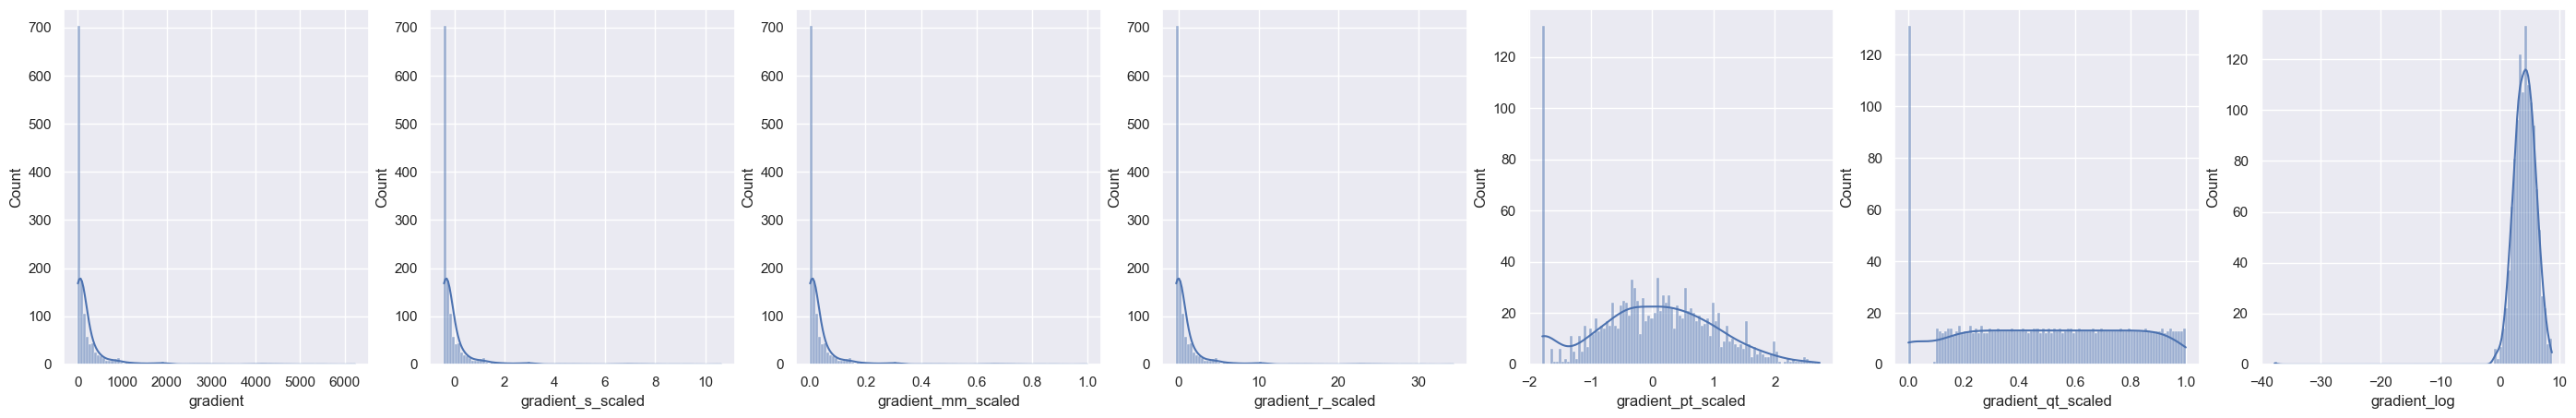

In [78]:
# plotting the distribution of gradient and scaled gradients for each article on multi plot

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True, ax=ax[0])
sns.histplot(data=df_labelled, x='gradient_s_scaled', bins=100, kde=True, ax=ax[1])
sns.histplot(data=df_labelled, x='gradient_mm_scaled', bins=100, kde=True, ax=ax[2])
sns.histplot(data=df_labelled, x='gradient_r_scaled', bins=100, kde=True, ax=ax[3])
sns.histplot(data=df_labelled, x='gradient_pt_scaled', bins=100, kde=True, ax=ax[4])
sns.histplot(data=df_labelled, x='gradient_qt_scaled', bins=100, kde=True, ax=ax[5])
sns.histplot(data=df_labelled, x='gradient_log', bins=100, kde=True, ax=ax[6])
plt.show()


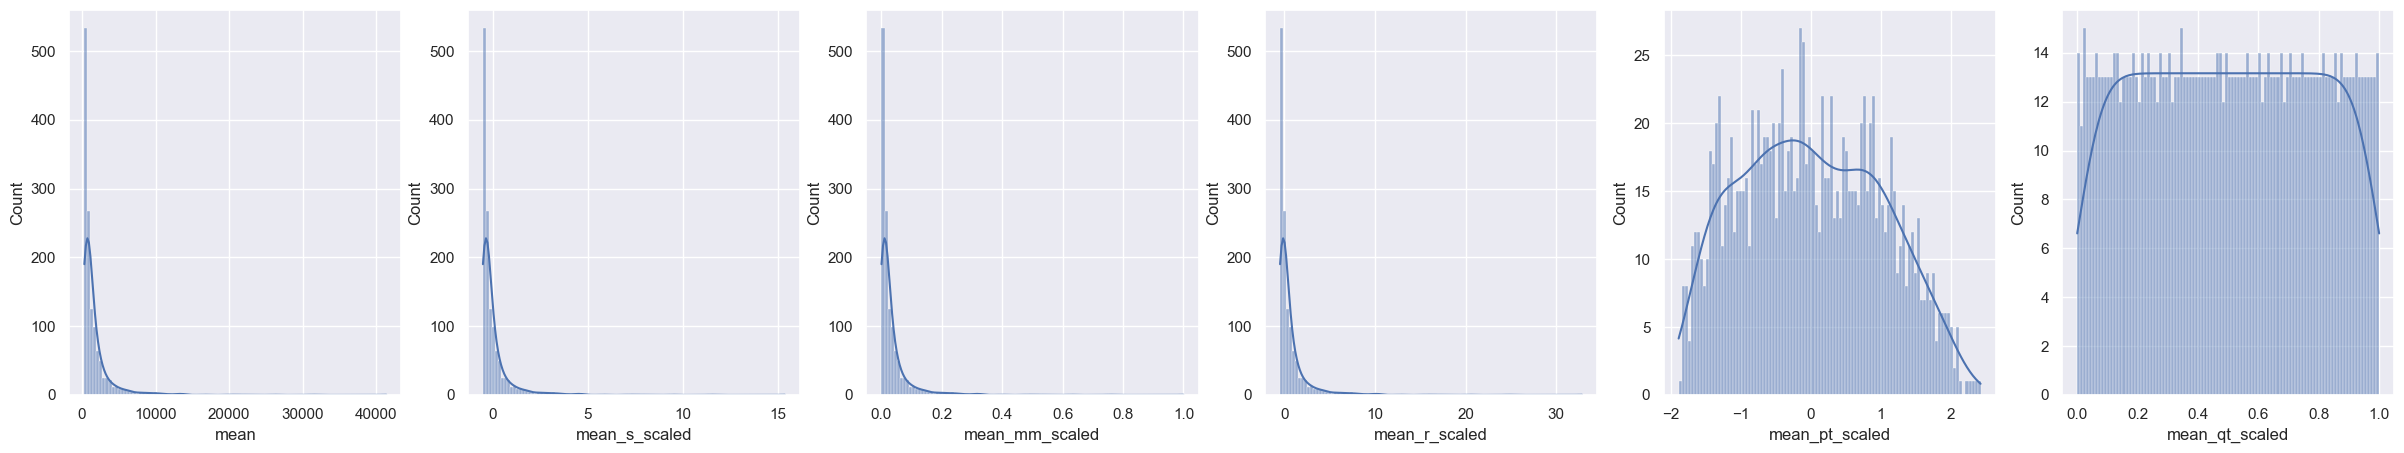

In [76]:
# plotting the distribution of mean  and scaled means for each article on multi plot

fig, ax = plt.subplots(1, 6, figsize=(30,5))
sns.histplot(data=df_labelled, x='mean', bins=100, kde=True, ax=ax[0])
sns.histplot(data=df_labelled, x='mean_s_scaled', bins=100, kde=True, ax=ax[1])
sns.histplot(data=df_labelled, x='mean_mm_scaled', bins=100, kde=True, ax=ax[2])
sns.histplot(data=df_labelled, x='mean_r_scaled', bins=100, kde=True, ax=ax[3])
sns.histplot(data=df_labelled, x='mean_pt_scaled', bins=100, kde=True, ax=ax[4])
sns.histplot(data=df_labelled, x='mean_qt_scaled', bins=100, kde=True, ax=ax[5])
plt.show()


In [20]:
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,...,mean_s_scaled,gradient_s_scaled,mean_mm_scaled,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today,3660000,1170000,...,-0.041100,-0.243732,0.030758,0.015152,0.575304,0.224138,0.670401,0.319537,0.711062,0.622623
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes,12310000,2230000,...,0.002321,-0.168943,0.033487,0.021918,0.666139,0.458843,0.741253,0.510717,0.731760,0.680218
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes,12310000,2230000,...,0.025118,-0.110459,0.034919,0.027209,0.713828,0.642380,0.775740,0.624606,0.744637,0.727888
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526,...,-0.412740,-0.293887,0.007406,0.010614,-0.202149,0.066741,-0.568886,0.139230,0.326831,0.544073
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000,...,0.029421,-0.169829,0.035189,0.021837,0.722830,0.456062,0.782059,0.508799,0.746813,0.679107


In [93]:
GRD_THRESHOLD_UPPER = 0.8
GRD_THRESHOLD_LOWER = -0.8
VAL_ARR_THRESHOLD_UPPER = 0.8
VAL_ARR_THRESHOLD_LOWER = -0.8

def get_label(row, colums):
    gradient_index = colums.index('gradient_pt_scaled')
    mean_index = colums.index('mean_pt_scaled')

    if row[gradient_index] > GRD_THRESHOLD_UPPER or row[mean_index] > VAL_ARR_THRESHOLD_UPPER:
        return "trending"
    
    elif row[gradient_index] < GRD_THRESHOLD_LOWER or row[mean_index] < VAL_ARR_THRESHOLD_LOWER:
        return "diminishing"
    
    else:
        return "neutral"

In [94]:
# label each row

df_labelled['label'] = df_labelled.apply(lambda x: get_label(x, list(df_labelled.columns)), axis=1)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,...,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,label,text,mean_log,gradient_log
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,today,3660000,1170000,...,0.575304,0.224138,0.670401,0.319537,0.711062,0.622623,neutral,â€˜The Godfather of AIâ€™ leaves Google and wa...,7.356024,4.548600
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,straitstimes,12310000,2230000,...,0.666139,0.458843,0.741253,0.510717,0.731760,0.680218,neutral,â€˜The Godfather of AI' leaves Google and warn...,7.425119,4.917789
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,straitstimes.com,1229,2023-05-07,straitstimes,12310000,2230000,...,0.713828,0.642380,0.775740,0.624606,0.744637,0.727888,neutral,â€˜She left an incredible legacy': Tributes po...,7.459569,5.134032
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,mustsharenews.com,462,2023-05-09,mustsharenews,2010000,823526,...,-0.202149,0.066741,-0.568886,0.139230,0.326831,0.544073,neutral,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,6.408529,4.192680
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,channelnewsasia.com,1416,2023-05-09,channelnewsasia,14760000,2330000,...,0.722830,0.456062,0.782059,0.508799,0.746813,0.679107,neutral,â€˜I was just super pumpedâ€™: Singapore's Sha...,7.465941,4.914124


### EDA of target variables

In [95]:
# Perform basic data exploration of target variable

df_labelled['label'].value_counts()


neutral        505
diminishing    414
trending       398
Name: label, dtype: int64

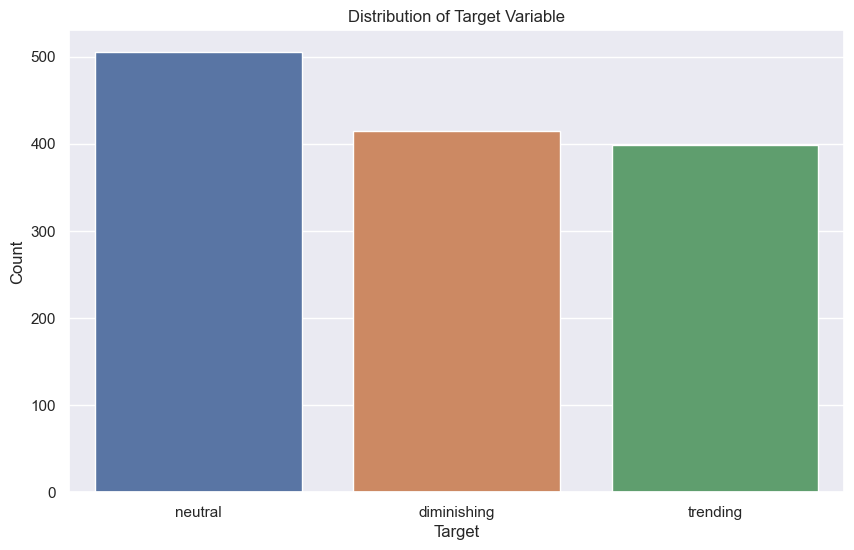

In [96]:
# Plot the distribution of target variable using Seaborn. 

plt.figure(figsize=(10, 6))
sns.countplot(data=df_labelled, x='label')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [97]:
# merge the labelled dataframe with the original dataframe to get the full dataset with labels

df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
df_combined.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,facebook_interactions_abs_change,label
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,0.0,neutral
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,101.0,neutral
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,182.0,neutral
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,49.0,neutral
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,25.0,neutral


In [98]:
unique_articles = df_combined['link'].unique()
new_df = pd.DataFrame()

for article in unique_articles:
    df_slice = df_combined[df_combined['link'] == article].reset_index(drop=True)
    df_slice = df_slice.reset_index().rename(columns={'index': 'day'})
    df_slice['day'] = df_slice['day'] + 1

    new_df = new_df.append(df_slice)

new_df.head(20)

,day,published,headline,summary,link,domain,facebook_interactions,date_extracted,facebook_interactions_abs_change,label
0,1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,0.0,neutral
1,2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,101.0,neutral
2,3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,182.0,neutral
3,4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,49.0,neutral
4,5,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,25.0,neutral
0,1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,0.0,neutral
1,2,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1514,2023-05-05,178.0,neutral
2,3,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1837,2023-05-07,323.0,neutral
3,4,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1849,2023-05-08,12.0,neutral
4,5,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1852,2023-05-09,3.0,neutral


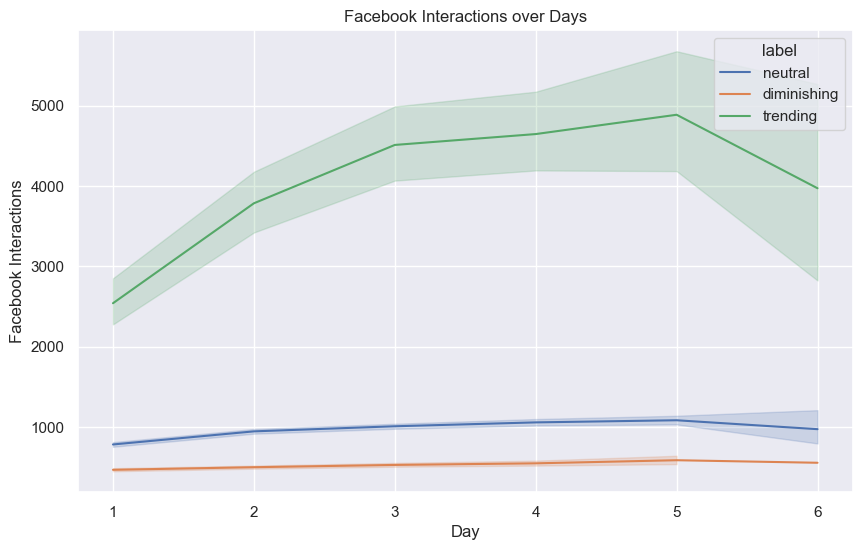

In [99]:
# Plot the facebook interactions for each article over days, coloured by label

plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='day', y='facebook_interactions', hue='label')
plt.title('Facebook Interactions over Days')
plt.xlabel('Day')
plt.ylabel('Facebook Interactions')
plt.show()

In [100]:
# previewing trending articles

df_labelled[df_labelled['label'] == 'trending'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,...,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,label,text,mean_log,gradient_log
10,2023-05-13 04:15:03,â€œNamelessâ€ Bak Chor Mee Stall: A truly hid...,They're open from 4.30am ðŸ˜‹,https://www.facebook.com/345185573000_62572379...,sg.style.yahoo.com,540,2023-05-14,yahoosingapore,5010000,561434,...,0.298256,1.866518,0.398734,1.075472,0.634419,0.859980,trending,â€œNamelessâ€ Bak Chor Mee Stall: A truly hid...,7.109879,5.965634
14,2023-05-09 13:15:04,Zhen Zheng Handmade Pau: Stunning pork belly &...,Such a hidden gem ðŸ˜‹,https://www.facebook.com/345185573000_62360295...,sg.style.yahoo.com,859,2023-05-12,yahoosingapore,5010000,561434,...,0.464923,1.010011,0.573617,0.800519,0.684668,0.782569,trending,Zhen Zheng Handmade Pau: Stunning pork belly &...,7.265080,5.462984
21,2023-05-19 09:45:58,Young man calls older man 'f*cking idiot' on M...,"In the video, the younger man said, ""This is n...",https://www.facebook.com/592308557475467_66432...,mothership.sg,1544,2023-05-20,mothership,6770000,1660000,...,0.907340,1.597887,0.899866,1.002391,0.785276,0.839351,trending,Young man calls older man 'f*cking idiot' on M...,7.588324,5.833348
23,2023-05-18 14:30:08,Young Lions coach Philippe Aw given 'time off'...,FAS said a technical review of the SEA Games p...,https://www.facebook.com/129011692114_10159214...,straitstimes.com,2340,2023-05-20,straitstimes,12310000,2230000,...,1.477494,1.592325,1.165549,1.000777,0.854881,0.836742,trending,Young Lions coach Philippe Aw given 'time off'...,7.892826,5.830415
27,2023-05-02 22:52:01,You&Me Teochew Fish Soup: Muslim-owned Teochew...,Hearty comfort food ðŸ˜‹,https://www.facebook.com/345185573000_61967285...,sg.style.yahoo.com,930,2023-05-04,yahoosingapore,5010000,561434,...,1.074250,1.956618,0.990504,1.098070,0.809176,0.869746,trending,You&Me Teochew Fish Soup: Muslim-owned Teochew...,7.687447,6.006353


In [101]:
# previewing not trending articles

df_labelled[df_labelled['label'] == 'diminishing'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,...,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,label,text,mean_log,gradient_log
5,2023-05-08 00:57:12,â€˜I now realise I cannot control everything i...,In the start of #CNAWomenâ€™s Motherâ€™s Day s...,https://www.facebook.com/93889432933_101596182...,cnalifestyle.channelnewsasia.com,445,2023-05-09,channelnewsasia,14760000,2330000,...,-0.315693,-0.204116,-1.019169,-0.495750,0.190729,0.295796,diminishing,â€˜I now realise I cannot control everything i...,6.146329,2.862201
11,2023-05-02 10:02:24,"library@esplanade to close on June 30, collect...","Officially opened in 2002, the library@esplana...",https://www.facebook.com/147858757571_10160136...,todayonline.com,328,2023-05-04,today,3660000,1170000,...,-0.400527,-0.225806,-1.509640,-0.607865,0.055206,0.265957,diminishing,"library@esplanade to close on June 30, collect...",5.892749,2.610070
12,2023-05-02 09:10:52,"library@esplanade to close on Jun 30, collecti...",Collections and programmes from the library@es...,https://www.facebook.com/93889432933_101596059...,channelnewsasia.com,313,2023-05-04,channelnewsasia,14760000,2330000,...,-0.440592,-0.301446,-1.820322,-1.788141,0.005191,0.000000,diminishing,"library@esplanade to close on Jun 30, collecti...",5.746203,-inf
16,2023-05-08 08:31:19,Zelenskyy says Russia will be defeated 'as Naz...,"""Just as we destroyed evil together then, we a...",https://www.facebook.com/93889432933_101596189...,channelnewsasia.com,365,2023-05-09,channelnewsasia,14760000,2330000,...,-0.376791,-0.192992,-1.353294,-0.446719,0.095998,0.313313,diminishing,Zelenskyy says Russia will be defeated 'as Naz...,5.970411,2.970414
17,2023-05-21 13:40:03,Zelenskyy has promised Ukraine will not use F-...,"F-16 warplanes could be used ""wherever Russian...",https://www.facebook.com/93889432933_101596440...,channelnewsasia.com,335,2023-05-22,channelnewsasia,14760000,2330000,...,-0.422749,-0.301446,-1.673707,-1.788141,0.025025,0.000000,diminishing,Zelenskyy has promised Ukraine will not use F-...,5.814131,-inf


In [102]:
# concatenate headline and summary columns
df_labelled['text'] = df_labelled['headline'] + ' ' + df_labelled['summary']

## Deep Learning Approaches

1. SetFit with Text Features only (Summary + Headline)
2. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors)
3. Combined models - Concat text embeddings with numerical features

#### 1. SetFit with Text Features only (Summary + Headline)


In [103]:
from datasets import load_dataset, Features, Value
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


In [104]:
def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})


def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

In [105]:
df_labelled_m1 = df_labelled.copy()
df_labelled_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 1316
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   published                     1317 non-null   datetime64[ns]
 1   headline                      1317 non-null   object        
 2   summary                       1317 non-null   object        
 3   link                          1317 non-null   object        
 4   domain                        1317 non-null   object        
 5   facebook_interactions         1317 non-null   int64         
 6   date_extracted                1317 non-null   datetime64[ns]
 7   domain_group                  1317 non-null   object        
 8   mean_monthly_visits           1317 non-null   int64         
 9   mean_monthly_unique_visitors  1317 non-null   int64         
 10  mean                          1317 non-null   float64       
 11  gradient                      

In [106]:
df_train_test_m1 = df_labelled_m1[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'label']]
df_train_test_m1

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,neutral
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,diminishing
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,trending


In [107]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m1['label'] = df_train_test_m1['label'].map(label_mapper)

# Train test split

train_df_m1, test_df_m1 = train_test_split(df_train_test_m1, test_size=0.2, random_state=42, stratify=df_train_test_m1['label'])

train_df_m1.to_parquet('data/train_df_m1.parquet')
test_df_m1.to_parquet('data/test_df_m1.parquet')

dataset_m1 = load_dataset("parquet", data_files={'train': "data/train_df_m1.parquet", 'test': "data/test_df_m1.parquet"})
train_dataset_m1 = dataset_m1["train"]
test_dataset_m1 = dataset_m1["test"]

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\4172689601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m1['label'] = df_train_test_m1['label'].map(label_mapper)


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 221.95it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-888fcf0191f70dc8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 499.20it/s]


In [108]:
# Load a SetFit model
model_m1 = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m1 = SetFitTrainer(
    model=model_m1,
    train_dataset=train_dataset_m1,
    eval_dataset=test_dataset_m1,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [109]:
trainer_m1.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 42.98it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [06:32<00:00, 392.66s/it]


In [110]:
# evalutating pred_y against test_y

def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})

test_y_m1 = test_dataset_m1.to_pandas()['label']
pred_y_m1 = model_m1.predict(test_dataset_m1.to_pandas()['text']).numpy()

res_m1 = evaluate_predictions(test_y_m1, pred_y_m1)
res_m1

,macro
accuracy,0.398
precision,0.413
recall,0.383
f1,0.380


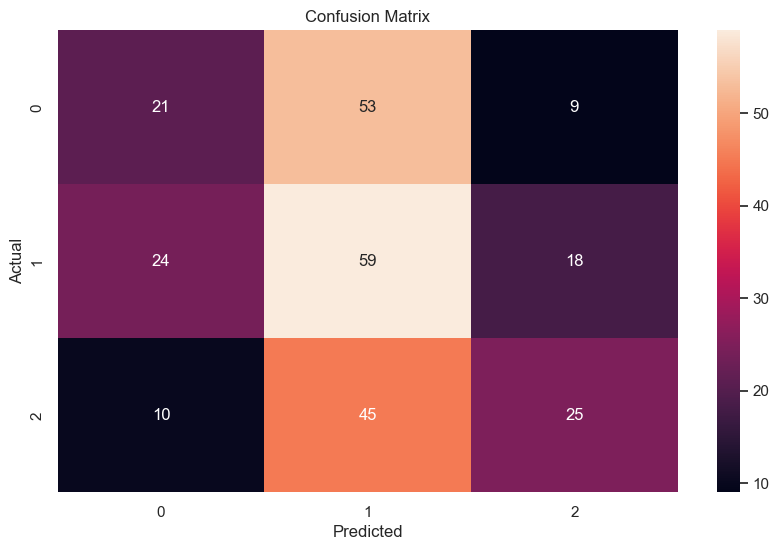

In [111]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

plot_confusion_matrix(test_y_m1, pred_y_m1)

### 2. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors)

In [112]:
df_labelled_m2 = df_labelled.copy()
df_train_test_m2 = df_labelled_m2[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'label']]
df_train_test_m2

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,neutral
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,diminishing
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,trending


In [113]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m2['label'] = df_train_test_m2['label'].map(label_mapper)


# combine mean_monthly_visits and mean_monthly_unique_visitors into text as text features

df_train_test_m2['text'] = df_train_test_m2['text'] + ' There are ' + df_train_test_m2['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2['mean_monthly_unique_visitors'].astype(str) + ' mean monthly unique visitors to the website.'
df_train_test_m2.drop(columns=['mean_monthly_visits', 'mean_monthly_unique_visitors'], inplace=True)
df_train_test_m2.head()

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\1153938972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2['label'] = df_train_test_m2['label'].map(label_mapper)
C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\1153938972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2['text'] = df_train_test_m2['text'] + ' There are ' + df_train_test_m2['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2['mean_monthly_unique_visit

,text,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,1
1,â€˜The Godfather of AI' leaves Google and warn...,1
2,â€˜She left an incredible legacy': Tributes po...,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,1


In [114]:
df_train_test_m2.iloc[0].text

'â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead Mr Geoffrey Hinton said he has quit his job at Google, where he has worked for more than decade and became one of the most respected voices in the field, so he can freely speak out about the risks of AI. A part of him, he said, now regrets his lifeâ€™s work.\n\n(via The New York Times) There are 3660000 mean monthly visitors to the website and 1170000 mean monthly unique visitors to the website.'

In [115]:
# Train test split

train_df_m2, test_df_m2 = train_test_split(df_train_test_m2, test_size=0.2, random_state=42, stratify=df_train_test_m2['label'])

train_df_m2.to_parquet('data/train_df_m2.parquet')
test_df_m2.to_parquet('data/test_df_m2.parquet')


dataset_m2 = load_dataset("parquet", data_files={'train': "data/train_df_m2.parquet", 'test': "data/test_df_m2.parquet"})
train_dataset_m2 = dataset_m2["train"]
test_dataset_m2 = dataset_m2["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 658.24it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-f6f76b29ea1db7c4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.24it/s]


In [116]:
# Load a SetFit model
model_m2 = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m2 = SetFitTrainer(
    model=model_m2,
    train_dataset=train_dataset_m2,
    eval_dataset=test_dataset_m2,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [117]:
trainer_m2.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 61.22it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [03:56<00:00, 236.96s/it]


In [118]:
test_y_m2 = test_dataset_m2.to_pandas()['label']
pred_y_m2 = model_m2.predict(test_dataset_m2.to_pandas()['text']).numpy()

In [119]:
test_y_m2 = test_dataset_m2.to_pandas()['label']
pred_y_m2 = model_m2.predict(test_dataset_m2.to_pandas()['text']).numpy()

res_m2 = evaluate_predictions(test_y_m2, pred_y_m2)
res_m2


,macro
accuracy,0.402
precision,0.421
recall,0.395
f1,0.398


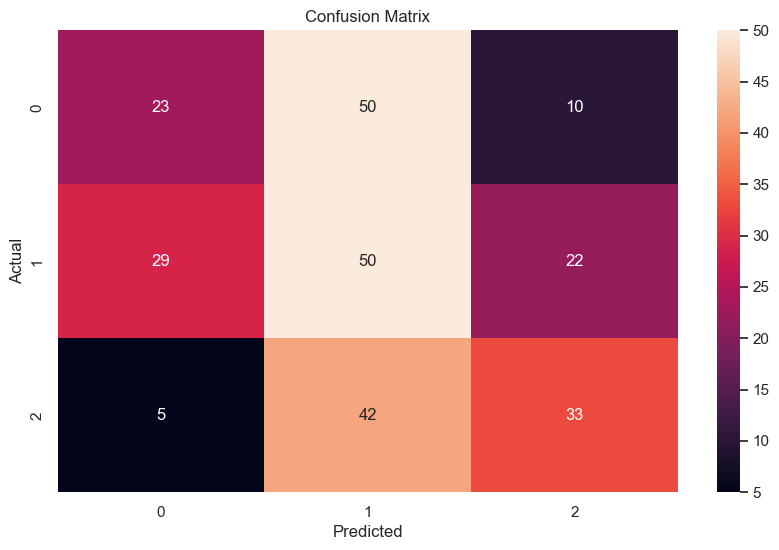

In [120]:
plot_confusion_matrix(test_y_m2, pred_y_m2)

### 2b. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors as bins)

In [121]:
df_labelled_m2b = df_labelled.copy()
df_train_test_m2b = df_labelled_m2b[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'label']]
df_train_test_m2b

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,neutral
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,diminishing
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,trending


In [122]:
# Normalise mean_monthly_visits and mean_monthly_unique_visitors

df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'] / df_train_test_m2b['mean_monthly_visits'].max()
df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'] / df_train_test_m2b['mean_monthly_unique_visitors'].max()

# converting mean_monthly_visits and mean_monthly_unique_visitors to bin

df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))
df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

df_train_test_m2b.head(10)

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2388436977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'] / df_train_test_m2b['mean_monthly_visits'].max()
C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2388436977.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'] / df_train_test_m2b['mean_monthly_unique_visitors']

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,lowest,moderate,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,high,high,neutral
2,â€˜She left an incredible legacy': Tributes po...,high,high,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,lowest,low,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,high,high,neutral
5,â€˜I now realise I cannot control everything i...,high,high,diminishing
6,â€˜I know what itâ€™s like to be homeless and ...,high,high,neutral
7,â€˜Do you think audiences are blind?â€™ Michel...,low,moderate,neutral
8,â€˜Coffee Shop King' died of haemorrhage after...,high,high,neutral
9,â€˜At least it was me and not anyone else': An...,high,high,neutral


In [123]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m2b['label'] = df_train_test_m2b['label'].map(label_mapper)


# combine mean_monthly_visits and mean_monthly_unique_visitors into text as text features

df_train_test_m2b['text'] = df_train_test_m2b['text'] + ' There are ' + df_train_test_m2b['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2b['mean_monthly_unique_visitors'].astype(str) + ' mean monthly unique visitors to the website.'
df_train_test_m2b.drop(columns=['mean_monthly_visits', 'mean_monthly_unique_visitors'], inplace=True)
df_train_test_m2b.head()

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2171122893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['label'] = df_train_test_m2b['label'].map(label_mapper)
C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2171122893.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['text'] = df_train_test_m2b['text'] + ' There are ' + df_train_test_m2b['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2b['mean_monthly_unique

,text,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,1
1,â€˜The Godfather of AI' leaves Google and warn...,1
2,â€˜She left an incredible legacy': Tributes po...,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,1


In [124]:
df_train_test_m2b.text.iloc[0]

'â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead Mr Geoffrey Hinton said he has quit his job at Google, where he has worked for more than decade and became one of the most respected voices in the field, so he can freely speak out about the risks of AI. A part of him, he said, now regrets his lifeâ€™s work.\n\n(via The New York Times) There are lowest mean monthly visitors to the website and moderate mean monthly unique visitors to the website.'

In [125]:
# Train test split

train_df_m2b, test_df_m2b = train_test_split(df_train_test_m2b, test_size=0.2, random_state=42, stratify=df_train_test_m2b['label'])

train_df_m2b.to_parquet('data/train_df_m2b.parquet')
test_df_m2b.to_parquet('data/test_df_m2b.parquet')


dataset_m2b = load_dataset("parquet", data_files={'train': "data/train_df_m2b.parquet", 'test': "data/test_df_m2b.parquet"})
train_dataset_m2b = dataset_m2b["train"]
test_dataset_m2b = dataset_m2b["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-383c8c9d69e98f4e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 1753.47it/s]


In [126]:
# Load a SetFit model
model_m2b = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m2b = SetFitTrainer(
    model=model_m2b,
    train_dataset=train_dataset_m2b,
    eval_dataset=test_dataset_m2b,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [127]:
trainer_m2b.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 43.07it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [03:44<00:00, 224.78s/it]


In [128]:
test_y_m2b = test_dataset_m2b.to_pandas()['label']
pred_y_m2b = model_m2b.predict(test_dataset_m2b.to_pandas()['text']).numpy()

In [129]:
test_y_m2b = test_dataset_m2b.to_pandas()['label']
pred_y_m2b = model_m2b.predict(test_dataset_m2b.to_pandas()['text']).numpy()

res_m2b = evaluate_predictions(test_y_m2b, pred_y_m2b)
res_m2b


,macro
accuracy,0.413
precision,0.448
recall,0.404
f1,0.410


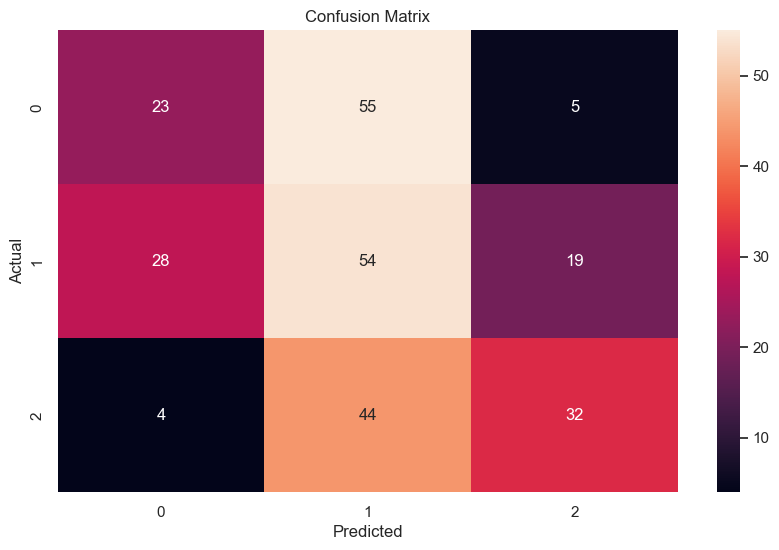

In [130]:
plot_confusion_matrix(test_y_m2b, pred_y_m2b)


### 3. Combined models - Concat text embeddings with numerical features

In [131]:
df_labelled_m3 = df_labelled.copy()
df_train_test_m3 = df_labelled_m3[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m3['label'] = df_train_test_m3['label'].map(label_mapper)
df_train_test_m3

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2796865243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m3['label'] = df_train_test_m3['label'].map(label_mapper)


,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,1
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,1
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,1
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,1
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,1
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,0
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,2


In [132]:
df_train_test_m3.label.value_counts()

1    505
0    414
2    398
Name: label, dtype: int64

In [133]:
# Create train, val and test datasets

train_val_df_m3, test_df_m3 = train_test_split(df_train_test_m3, test_size=0.2, random_state=42, stratify=df_train_test_m3['label'])
train_df_m3, val_df_m3 = train_test_split(train_val_df_m3, test_size=0.2, random_state=42, stratify=train_val_df_m3['label'])

In [134]:
train_df_m3.shape, val_df_m3.shape, test_df_m3.shape 

((842, 4), (211, 4), (264, 4))

In [135]:
train_df_m3.label.value_counts(), val_df_m3.label.value_counts(), test_df_m3.label.value_counts()

(1    323
 0    265
 2    254
 Name: label, dtype: int64,
 1    81
 0    66
 2    64
 Name: label, dtype: int64,
 1    101
 0     83
 2     80
 Name: label, dtype: int64)

In [136]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler_m3 = MinMaxScaler()
train_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m3.fit_transform(train_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
train_df_m3

# normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df

val_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m3.transform(val_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
val_df_m3

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m3.transform(test_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
test_df_m3

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
1108,Arteta apologises for unacceptable Arsenal 'co...,0.832321,0.955429,2
640,"Man in China, who works in maritime industry, ...",0.453160,0.701374,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,0.127382,0.328548,1
215,Sunny side up: Woman in Sabah taps sizzling he...,0.832321,0.955429,2
1163,6 suspects appear in court for Hong Kong socia...,0.832321,0.955429,0
...,...,...,...,...
123,Transformers: Rise Of The Beasts will have its...,1.000000,1.000000,0
881,Firsthand: Housewife who once felt 'worthless'...,0.453160,0.701374,1
537,"PAP, WP MPs file parliamentary questions on mi...",1.000000,1.000000,0
206,Swimming: Singapore's Jonathan Tan meets Olymp...,0.240309,0.482975,0


In [137]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [138]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[['mean_monthly_visits', 'mean_monthly_unique_visitors']].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [139]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [140]:
# Create Datasets
train_dataset_m3 = CustomDataset(train_df_m3)
val_dataset_m3 = CustomDataset(val_df_m3)
test_dataset_m3 = CustomDataset(test_df_m3)

# Create DataLoaders
batch_size = 32  
train_dataloader_m3 = DataLoader(train_dataset_m3, batch_size=batch_size, shuffle=True)
val_dataloader_m3 = DataLoader(val_dataset_m3, batch_size=batch_size, shuffle=False)
test_dataloader_m3 = DataLoader(test_dataset_m3, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
# sentence_model = SentenceTransformer('all-mpnet-base-v2')
sentence_model_m3 = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model_m3 = NumericModel(2, 64, 512)  

# Instantiate FinalModel
final_model_m3 = FinalModel(896, 64, 3)

# Define the criterion and the optimizer
criterion_m3 = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_m3 = Adam(list(numeric_model_m3.parameters()) + list(final_model_m3.parameters()) + list(sentence_model_m3.parameters()), lr=0.0001)

In [141]:
N_EPOCHS = 100

# Save train and validation losses

train_losses_m3 = []
val_losses_m3 = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader_m3, sentence_model_m3, numeric_model_m3, final_model_m3, criterion_m3, optimizer_m3)
    valid_loss = evaluate(val_dataloader_m3, sentence_model_m3, numeric_model_m3, final_model_m3, criterion_m3)
    train_losses_m3.append(train_loss)
    val_losses_m3.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 30 and val_losses_m3[epoch-1] < val_losses_m3[epoch] and val_losses_m3[epoch-2] < val_losses_m3[epoch-1]:
        break

Epoch 0: Train Loss: 1.0964490837521024, Validation Loss: 1.091121758733477
Epoch 1: Train Loss: 1.090787198808458, Validation Loss: 1.0882026297705514
Epoch 2: Train Loss: 1.088604004294784, Validation Loss: 1.0862746919904436
Epoch 3: Train Loss: 1.083930421758581, Validation Loss: 1.0837853125163488
Epoch 4: Train Loss: 1.081605041468585, Validation Loss: 1.081739068031311
Epoch 5: Train Loss: 1.0775207192809493, Validation Loss: 1.0802305425916399
Epoch 6: Train Loss: 1.075859546661377, Validation Loss: 1.07754271371024
Epoch 7: Train Loss: 1.073368580253036, Validation Loss: 1.075419817652021
Epoch 8: Train Loss: 1.069314890437656, Validation Loss: 1.0736675092152186
Epoch 9: Train Loss: 1.0693152436503657, Validation Loss: 1.0709962163652693
Epoch 10: Train Loss: 1.0639490021599665, Validation Loss: 1.0692426988056727
Epoch 11: Train Loss: 1.0600619095343131, Validation Loss: 1.0667073556355067
Epoch 12: Train Loss: 1.0594400918042217, Validation Loss: 1.0648490360804967
Epoch 13

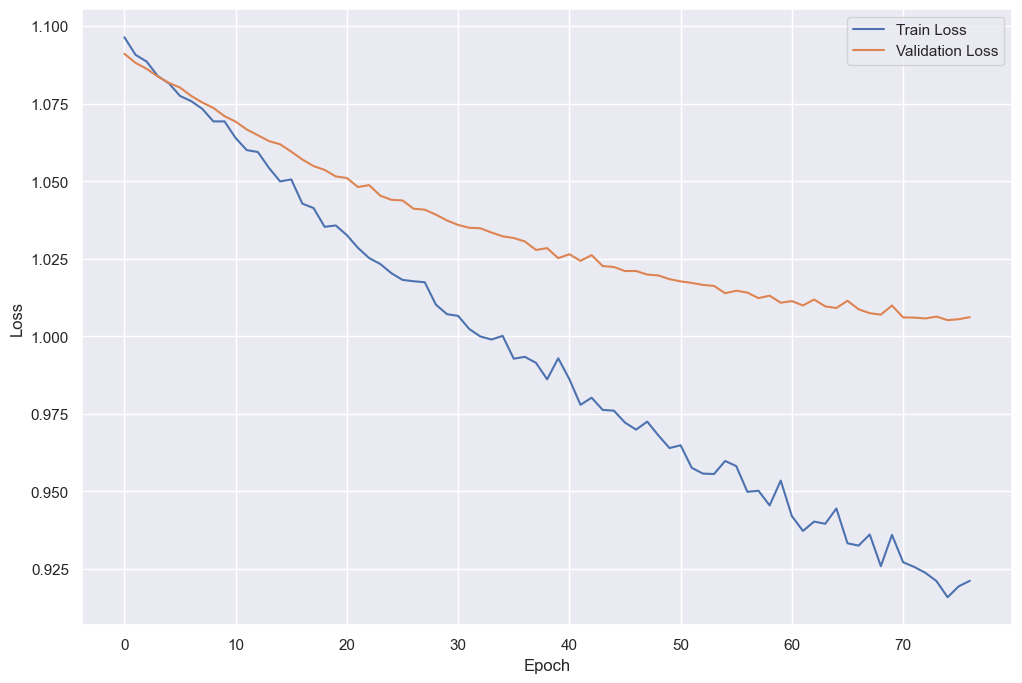

In [142]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses_m3, label='Train Loss')
plt.plot(val_losses_m3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
final_model_m3.eval()  # Set the model to evaluation mode
sentence_model_m3.eval()
numeric_model_m3.eval()

pred_y_m3 = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader_m3:  # We don't care about labels here
        texts = [sentence_model_m3.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model_m3(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model_m3(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        pred_y_m3.extend(predicted.tolist())  # Convert tensor to list and append to predictions

pred_y_m3 = np.array(pred_y_m3)  # Convert predictions to NumPy array

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\2447301300.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  texts = torch.tensor(texts, dtype=torch.float)


In [144]:
# plot confusion matrix

test_y_m3 = test_df_m3['label'].values

res_m3 = evaluate_predictions(test_y_m3, pred_y_m3)
res_m3

,macro
accuracy,0.420
precision,0.432
recall,0.421
f1,0.424


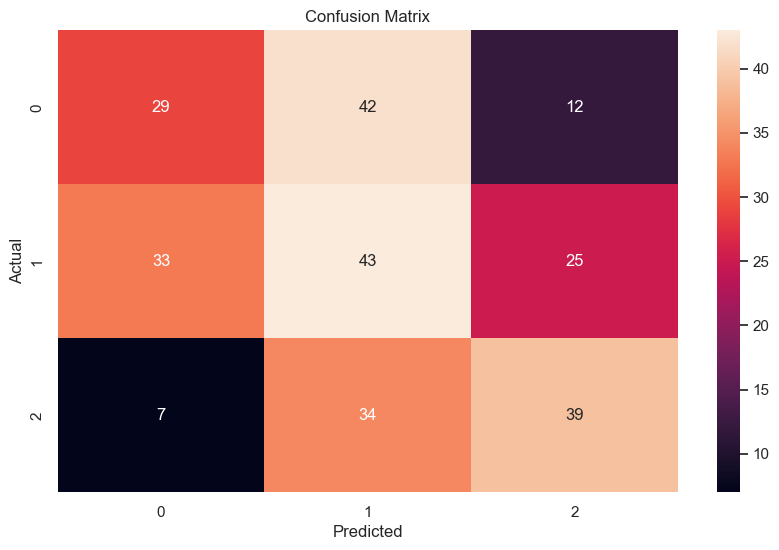

In [145]:
plot_confusion_matrix(test_y_m3, pred_y_m3)

### 3b. Combined models - Concat text embeddings with numerical features (one hot encoding of domains only)

In [146]:
df_labelled_m3b = df_labelled.copy()
df_train_test_m3b = df_labelled_m3b[['text', 'domain_group', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m3b['label'] = df_train_test_m3b['label'].map(label_mapper)

# one-hot encode domain_group
df_train_test_m3b = pd.get_dummies(df_train_test_m3b, columns=['domain_group'])

df_train_test_m3b

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\1911233606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m3b['label'] = df_train_test_m3b['label'].map(label_mapper)


,text,label,domain_group_asiaone,domain_group_businesstimes,domain_group_channelnewsasia,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,â€˜The Godfather of AI' leaves Google and warn...,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,â€˜She left an incredible legacy': Tributes po...,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",1,0,0,0,0,0,0,0,0,0,0,0,1,0
1313,#trending: Primary 3 mathematics question with...,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1314,#trending: Former SIA cabin crew offers explan...,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1315,#trending: Blackpink fans criticise fellow con...,2,0,0,0,0,0,0,0,0,0,0,0,1,0


In [147]:
domain_group_cols = list(df_train_test_m3b.columns[2:])
domain_group_cols

['domain_group_asiaone',
 'domain_group_businesstimes',
 'domain_group_channelnewsasia',
 'domain_group_goodyfeed',
 'domain_group_mothership',
 'domain_group_mustsharenews',
 'domain_group_ricemedia',
 'domain_group_stomp',
 'domain_group_straitstimes',
 'domain_group_thenewpaper',
 'domain_group_theonlinecitizen',
 'domain_group_today',
 'domain_group_yahoosingapore']

In [148]:
# Create train, val and test datasets
train_val_df_m3b, test_df_m3b = train_test_split(df_train_test_m3b, test_size=0.2, random_state=42, stratify=df_train_test_m3b['label'])
train_df_m3b, val_df_m3b = train_test_split(train_val_df_m3b, test_size=0.2, random_state=42, stratify=train_val_df_m3b['label'])

In [149]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [150]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[domain_group_cols].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [151]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [152]:
# Create Datasets
train_dataset_m3b = CustomDataset(train_df_m3b)
val_dataset_m3b = CustomDataset(val_df_m3b)
test_dataset_m3b = CustomDataset(test_df_m3b)

# Create DataLoaders
batch_size = 32  
train_dataloader_m3b = DataLoader(train_dataset_m3b, batch_size=batch_size, shuffle=True)
val_dataloader_m3b = DataLoader(val_dataset_m3b, batch_size=batch_size, shuffle=False)
test_dataloader_m3b = DataLoader(test_dataset_m3b, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
# sentence_model = SentenceTransformer('all-mpnet-base-v2')
sentence_model_m3b = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model_m3b = NumericModel(len(domain_group_cols), 64, 512)  

# Instantiate FinalModel
final_model_m3b = FinalModel(896, 64, 3)

# Define the criterion and the optimizer
criterion_m3b = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_m3b = Adam(list(numeric_model_m3b.parameters()) + list(final_model_m3b.parameters()) + list(sentence_model_m3b.parameters()), lr=0.0001)

In [153]:
N_EPOCHS = 100

# Save train and validation losses

train_losses_m3b = []
val_losses_m3b = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader_m3b, sentence_model_m3b, numeric_model_m3b, final_model_m3b, criterion_m3b, optimizer_m3b)
    valid_loss = evaluate(val_dataloader_m3b, sentence_model_m3b, numeric_model_m3b, final_model_m3b, criterion_m3b)
    train_losses_m3b.append(train_loss)
    val_losses_m3b.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 30 and val_losses_m3b[epoch-1] < val_losses_m3b[epoch] and val_losses_m3b[epoch-2] < val_losses_m3b[epoch-1]:
        break

Epoch 0: Train Loss: 1.0965277353922527, Validation Loss: 1.0925557272774833
Epoch 1: Train Loss: 1.085913552178277, Validation Loss: 1.0853696720940726
Epoch 2: Train Loss: 1.0779054253189653, Validation Loss: 1.08026123046875
Epoch 3: Train Loss: 1.0674846834606595, Validation Loss: 1.0750772953033447
Epoch 4: Train Loss: 1.059330768055386, Validation Loss: 1.0715355021612984
Epoch 5: Train Loss: 1.052973018752204, Validation Loss: 1.0683123895100184
Epoch 6: Train Loss: 1.0456843000871163, Validation Loss: 1.0653555393218994
Epoch 7: Train Loss: 1.0425226864991364, Validation Loss: 1.0624537127358573
Epoch 8: Train Loss: 1.03625824937114, Validation Loss: 1.0608570916312081
Epoch 9: Train Loss: 1.0288116225489863, Validation Loss: 1.0577989646366663
Epoch 10: Train Loss: 1.0263687018994931, Validation Loss: 1.0561831423214503
Epoch 11: Train Loss: 1.0215029451582167, Validation Loss: 1.0539374181202479
Epoch 12: Train Loss: 1.0202674446282562, Validation Loss: 1.0508799127170019
Epo

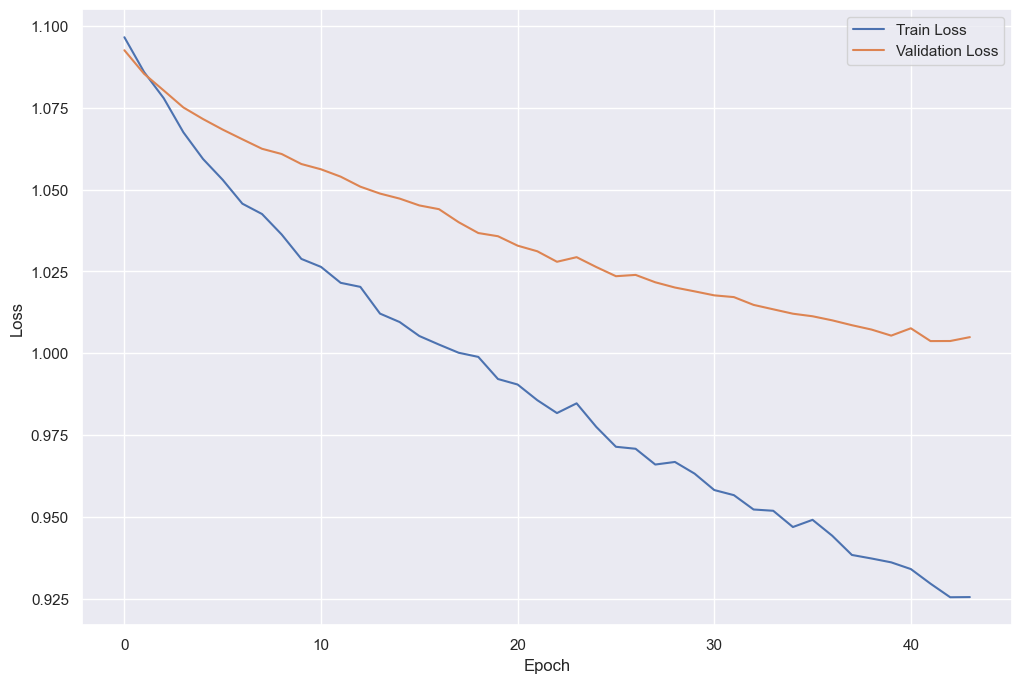

In [154]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses_m3b, label='Train Loss')
plt.plot(val_losses_m3b, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [155]:
final_model_m3b.eval()  # Set the model to evaluation mode
sentence_model_m3b.eval()
numeric_model_m3b.eval()

pred_y_m3b = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader_m3b:  # We don't care about labels here
        texts = [sentence_model_m3b.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model_m3b(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model_m3b(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        pred_y_m3b.extend(predicted.tolist())  # Convert tensor to list and append to predictions

pred_y_m3b = np.array(pred_y_m3b)  # Convert predictions to NumPy array

In [156]:
# plot confusion matrix

test_y_m3b = test_df_m3b['label'].values

res_m3b = evaluate_predictions(test_y_m3b, pred_y_m3b)
res_m3b

,macro
accuracy,0.439
precision,0.452
recall,0.431
f1,0.418


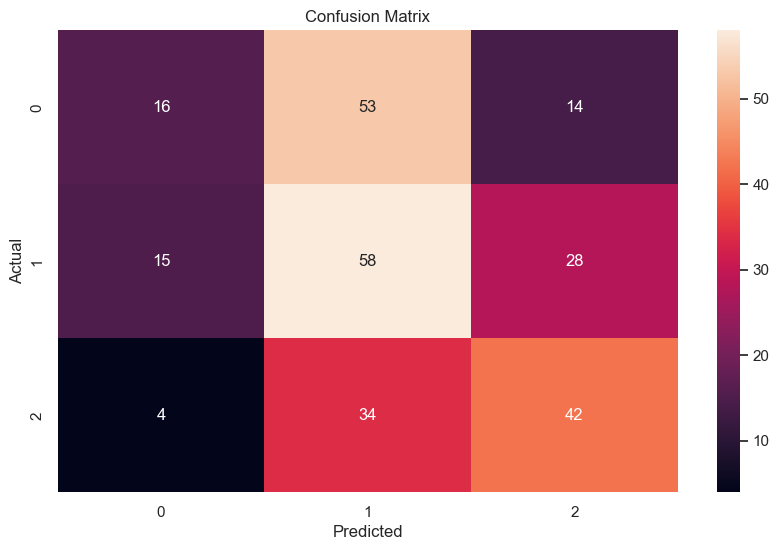

In [157]:
plot_confusion_matrix(test_y_m3b, pred_y_m3b)


### 4. Multimodel Transformers

In [158]:
df_labelled_m4 = df_labelled.copy()
df_train_test_m4 = df_labelled_m4[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m4['label'] = df_train_test_m4['label'].map(label_mapper)
df_train_test_m4

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\85663514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m4['label'] = df_train_test_m4['label'].map(label_mapper)


,text,mean_monthly_visits,mean_monthly_unique_visitors,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,1
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,1
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,1
...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,1
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,1
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,0
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,2


In [159]:
# Train test split

train_df_m4, test_df_m4 = train_test_split(df_train_test_m4, test_size=0.2, random_state=42, stratify=df_train_test_m4['label'])

In [160]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler_m4 = MinMaxScaler()
train_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m4.fit_transform(train_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
train_df_m4

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m4.transform(test_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
test_df_m4

,text,mean_monthly_visits,mean_monthly_unique_visitors,label
1108,Arteta apologises for unacceptable Arsenal 'co...,0.832321,0.955429,2
640,"Man in China, who works in maritime industry, ...",0.453160,0.701374,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,0.127382,0.328548,1
215,Sunny side up: Woman in Sabah taps sizzling he...,0.832321,0.955429,2
1163,6 suspects appear in court for Hong Kong socia...,0.832321,0.955429,0
...,...,...,...,...
123,Transformers: Rise Of The Beasts will have its...,1.000000,1.000000,0
881,Firsthand: Housewife who once felt 'worthless'...,0.453160,0.701374,1
537,"PAP, WP MPs file parliamentary questions on mi...",1.000000,1.000000,0
206,Swimming: Singapore's Jonathan Tan meets Olymp...,0.240309,0.482975,0


In [161]:
train_df_m4.to_parquet('data/train_df_m4.parquet')
test_df_m4.to_parquet('data/test_df_m4.parquet')

dataset_m4 = load_dataset("parquet", data_files={'train': "data/train_df_m4.parquet", 'test': "data/test_df_m4.parquet"})
train_dataset_m4 = dataset_m4["train"]
test_dataset_m4 = dataset_m4["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 666.71it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-fb5e74c83be7ace2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.00it/s]


In [162]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer

data_df = train_df_m4.copy()
text_cols = ['text']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label' 
numerical_cols = ['mean_monthly_visits', 'mean_monthly_unique_visitors']
label_list = ['diminishing', 'neutral', 'trending'] # what each label class represents

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

torch_dataset = load_data(
    data_df,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

test_df_m4 = test_df_m4.reset_index(drop=True)
test_df_m4

test_dataset_m4 = load_data(
    test_df_m4,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)




In [163]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

num_labels = 3
config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
    num_labels=num_labels,
    numerical_feat_dim=torch_dataset.numerical_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
)
config.tabular_config = tabular_config

model_m4 = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_combiner.num_layer.weight', 'tabul

In [164]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=32,
    num_train_epochs=5,
    # evaluate_during_training=True,
    logging_steps=25,
)

trainer = Trainer(
  model=model_m4,
  args=training_args,
  train_dataset=torch_dataset,
  eval_dataset=test_dataset_m4,
)

trainer.train()

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 15%|█▌        | 25/165 [05:39<31:47, 13.63s/it]

{'loss': 1.0937, 'learning_rate': 4.242424242424243e-05, 'epoch': 0.76}


 30%|███       | 50/165 [11:19<26:08, 13.64s/it]

{'loss': 1.046, 'learning_rate': 3.484848484848485e-05, 'epoch': 1.52}


 45%|████▌     | 75/165 [17:00<20:37, 13.75s/it]

{'loss': 0.9173, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.27}


 61%|██████    | 100/165 [22:43<14:41, 13.55s/it]

{'loss': 0.7399, 'learning_rate': 1.9696969696969697e-05, 'epoch': 3.03}


 76%|███████▌  | 125/165 [28:25<09:06, 13.66s/it]

{'loss': 0.4772, 'learning_rate': 1.2121212121212122e-05, 'epoch': 3.79}


 91%|█████████ | 150/165 [34:05<03:24, 13.63s/it]

{'loss': 0.3305, 'learning_rate': 4.5454545454545455e-06, 'epoch': 4.55}


100%|██████████| 165/165 [37:29<00:00, 13.64s/it]

{'train_runtime': 2249.7919, 'train_samples_per_second': 2.34, 'train_steps_per_second': 0.073, 'train_loss': 0.7209110173312101, 'epoch': 5.0}


TrainOutput(global_step=165, training_loss=0.7209110173312101, metrics={'train_runtime': 2249.7919, 'train_samples_per_second': 2.34, 'train_steps_per_second': 0.073, 'train_loss': 0.7209110173312101, 'epoch': 5.0})

In [165]:

pred_y_m4 = trainer.predict(test_dataset_m4)


100%|██████████| 33/33 [00:01<00:00, 18.07it/s]


In [166]:
test_y_m4 = test_df_m4['label']
pred_y_m4 = pred_y_m4.predictions[0].argmax(axis=1)

res_m4 = evaluate_predictions(test_y_m4, pred_y_m4)
res_m4

,macro
accuracy,0.428
precision,0.428
recall,0.432
f1,0.429


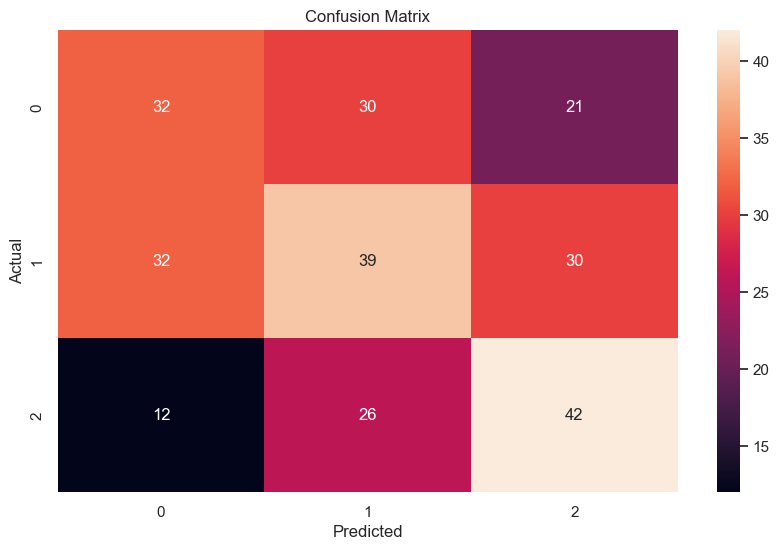

In [167]:
plot_confusion_matrix(test_y_m4, pred_y_m4)


### 4b. Multimodel Transformers with categorical domain encoding

In [168]:
df_labelled_m4b = df_labelled.copy()
df_train_test_m4b = df_labelled_m4b[['text', 'domain_group', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m4b['label'] = df_train_test_m4b['label'].map(label_mapper)

df_train_test_m4b = pd.get_dummies(df_train_test_m4b, columns=['domain_group'])

df_train_test_m4b

C:\Users\edmun\AppData\Local\Temp\ipykernel_30704\3871405470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m4b['label'] = df_train_test_m4b['label'].map(label_mapper)


,text,label,domain_group_asiaone,domain_group_businesstimes,domain_group_channelnewsasia,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,â€˜The Godfather of AI' leaves Google and warn...,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,â€˜She left an incredible legacy': Tributes po...,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",1,0,0,0,0,0,0,0,0,0,0,0,1,0
1313,#trending: Primary 3 mathematics question with...,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1314,#trending: Former SIA cabin crew offers explan...,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1315,#trending: Blackpink fans criticise fellow con...,2,0,0,0,0,0,0,0,0,0,0,0,1,0


In [169]:
domain_group_cols = list(df_train_test_m4b.columns[2:])
domain_group_cols

['domain_group_asiaone',
 'domain_group_businesstimes',
 'domain_group_channelnewsasia',
 'domain_group_goodyfeed',
 'domain_group_mothership',
 'domain_group_mustsharenews',
 'domain_group_ricemedia',
 'domain_group_stomp',
 'domain_group_straitstimes',
 'domain_group_thenewpaper',
 'domain_group_theonlinecitizen',
 'domain_group_today',
 'domain_group_yahoosingapore']

In [170]:
train_df_m4b, test_df_m4b = train_test_split(df_train_test_m4b, test_size=0.2, random_state=42, stratify=df_train_test_m4b['label'])


In [171]:
train_df_m4b.to_parquet('data/train_df_m4b.parquet')
test_df_m4b.to_parquet('data/test_df_m4b.parquet')

dataset_m4b = load_dataset("parquet", data_files={'train': "data/train_df_m4b.parquet", 'test': "data/test_df_m4b.parquet"})
train_dataset_m4b = dataset_m4b["train"]
test_dataset_m4b = dataset_m4b["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1000.43it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-49a00d9253aab1d6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 990.98it/s]


In [172]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer

data_df = train_df_m4b.copy()
text_cols = ['text']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label' 
numerical_cols = domain_group_cols
# categorical_cols = domain_group_cols
label_list = ['diminishing', 'neutral', 'trending'] # what each label class represents

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

torch_dataset_m4b = load_data(
    data_df,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

test_df_m4b = test_df_m4b.reset_index(drop=True)
test_df_m4b

test_dataset_m4b = load_data(
    test_df_m4b,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

In [173]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

num_labels = 3
config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
    num_labels=num_labels,
    numerical_feat_dim=torch_dataset_m4b.numerical_feats.shape[1],
    # cat_feat_dim=torch_dataset_m4b.cat_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
)
config.tabular_config = tabular_config

model_m4b = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['tabular_combiner.num_layer.weight', 'tabul

In [174]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=32,
    num_train_epochs=5,
    # evaluate_during_training=True,
    logging_steps=25,
)

trainer_m4b = Trainer(
  model=model_m4b,
  args=training_args,
  train_dataset=torch_dataset_m4b,
  eval_dataset=test_dataset_m4b,
)

trainer_m4b.train()

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 15%|█▌        | 25/165 [05:53<32:42, 14.02s/it]

{'loss': 1.1099, 'learning_rate': 4.242424242424243e-05, 'epoch': 0.76}


 30%|███       | 50/165 [11:48<27:17, 14.24s/it]

{'loss': 1.111, 'learning_rate': 3.484848484848485e-05, 'epoch': 1.52}


 45%|████▌     | 75/165 [17:44<21:19, 14.22s/it]

{'loss': 1.0429, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.27}


 61%|██████    | 100/165 [23:39<15:24, 14.23s/it]

{'loss': 0.9808, 'learning_rate': 1.9696969696969697e-05, 'epoch': 3.03}


 76%|███████▌  | 125/165 [29:34<09:28, 14.21s/it]

{'loss': 0.8358, 'learning_rate': 1.2121212121212122e-05, 'epoch': 3.79}


 91%|█████████ | 150/165 [35:29<03:33, 14.21s/it]

{'loss': 0.7322, 'learning_rate': 4.5454545454545455e-06, 'epoch': 4.55}


100%|██████████| 165/165 [39:03<00:00, 14.20s/it]

{'train_runtime': 2343.2588, 'train_samples_per_second': 2.247, 'train_steps_per_second': 0.07, 'train_loss': 0.9424925081657641, 'epoch': 5.0}


TrainOutput(global_step=165, training_loss=0.9424925081657641, metrics={'train_runtime': 2343.2588, 'train_samples_per_second': 2.247, 'train_steps_per_second': 0.07, 'train_loss': 0.9424925081657641, 'epoch': 5.0})

In [175]:
pred_y_m4b = trainer_m4b.predict(test_dataset_m4b)


  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:01<00:00, 17.59it/s]


In [176]:
test_y_m4b = test_df_m4b['label']
pred_y_m4b = pred_y_m4b.predictions[0].argmax(axis=1)

res_m4b = evaluate_predictions(test_y_m4b, pred_y_m4b)
res_m4b

,macro
accuracy,0.428
precision,0.428
recall,0.438
f1,0.429


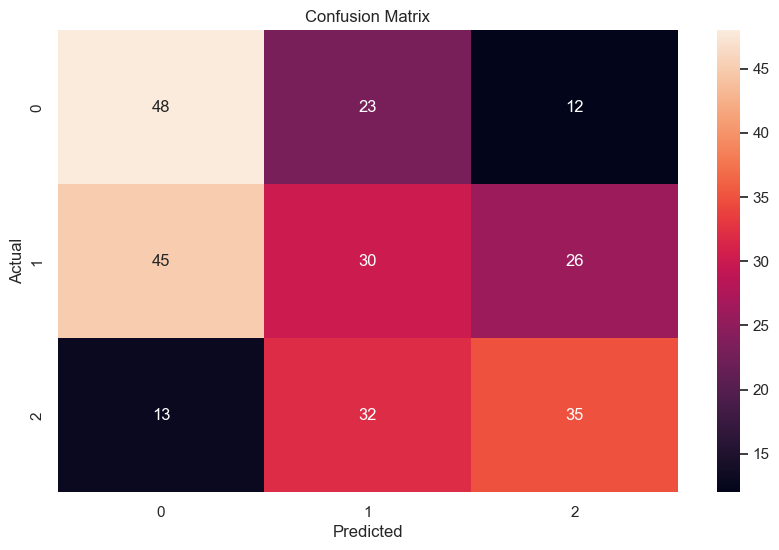

In [177]:
plot_confusion_matrix(test_y_m4b, pred_y_m4b)


### Comaparing Results M1, M2, M2b, M3, M3b, M4, M4b

In [178]:
# combine res_m1, res_m2, res_m3 into a dataframe

res_df = pd.concat([res_m1, res_m2, res_m2b, res_m3, res_m3b, res_m4, res_m4b], axis=1, keys=['SetFit (Text Only)', 'SetFit (Text + numerical)', 'SetFit (Text + binned numerical)', 'Concat (Visitor Count)', 'Concat (One-hot domain)','Multimodal (Visitor Count)','Multimodal (One-hot domain)']).droplevel(1, axis=1).T
res_df

,accuracy,precision,recall,f1
SetFit (Text Only),0.398,0.413,0.383,0.380
SetFit (Text + numerical),0.402,0.421,0.395,0.398
SetFit (Text + binned numerical),0.413,0.448,0.404,0.410
Concat (Visitor Count),0.420,0.432,0.421,0.424
Concat (One-hot domain),0.439,0.452,0.431,0.418
Multimodal (Visitor Count),0.428,0.428,0.432,0.429
Multimodal (One-hot domain),0.428,0.428,0.438,0.429


In [180]:
res_df.to_csv('results_100.csv')